In [3]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter


# Chemistry
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*') 
print(rdkit.__version__)

# Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, matthews_corrcoef

import warnings
import joblib
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'rdkit'

In [ ]:
data = pd.read_csv("data_train.csv",index_col=0).reset_index(drop=True)
data

Convert SMILES to rdkit mols: 100%|████| 12000/12000 [00:01<00:00, 11742.11it/s]


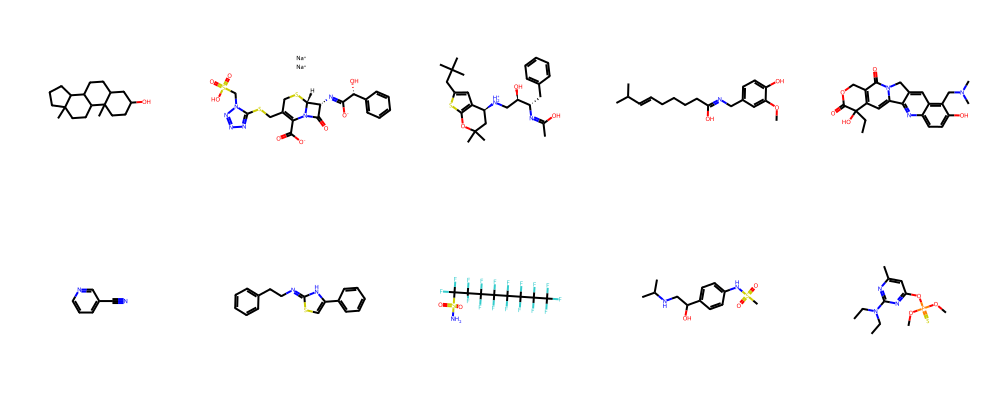

In [3]:
data['mol'] = [Chem.MolFromSmiles(smi) for smi in tqdm(data['smiles'], desc='Convert SMILES to rdkit mols')]
Draw.MolsToGridImage(data['mol'][:10], molsPerRow=5)

In [4]:
def standardize_mol(rd_mol):
    """
    Standardizes an RDKit molecule by performing a series of operations to improve consistency and quality.

    Parameters:
    - rd_mol (Chem.Mol): RDKit molecule to be standardized.

    Returns:
    - Chem.Mol or None: Standardized RDKit molecule if successful, or None if an error occurs during the standardization process.

    The standardization process includes the following steps:
    1. Metal disconnection: Disconnects metal atoms from the molecule.
    2. Normalization: Applies various normalization transformations to the molecule.
    3. Largest fragment selection: Chooses the largest fragment of the molecule.
    4. Uncharging: Removes charges from the molecule.
    5. Removal of molecules without any carbon atoms.
    6. Removal of molecules containing specific salts (e.g., Na, Zn).

    If any step fails or if the resulting molecule does not meet certain criteria, None is returned.
    """
    try:
        charger = rdMolStandardize.Uncharger()
        chooser = rdMolStandardize.LargestFragmentChooser()
        disconnector = rdMolStandardize.MetalDisconnector()
        normalizer = rdMolStandardize.Normalizer()
        carbon = Chem.MolFromSmarts('[#6]')
        salts = Chem.MolFromSmarts('[Na,Zn]')
        # rd_mol = disconnector.Disconnect(rd_mol)
        rd_mol = normalizer.normalize(rd_mol)
        rd_mol = chooser.choose(rd_mol)
        # rd_mol = charger.uncharge(rd_mol)
        # rd_mol = disconnector.Disconnect(rd_mol)
        rd_mol = normalizer.normalize(rd_mol)
        
        # Remove molecules without any carbons
        if len(rd_mol.GetSubstructMatches(carbon)) == 0:
            return None
        # Remove SMILES that still contain salts
        if len(rd_mol.GetSubstructMatches(salts)) > 0:
            return None
        return rd_mol
    except:
        return None

In [5]:
# Sanitize molecules
data['mol'] = data['mol'].apply(lambda x : standardize_mol(x))

# Drop all molecules that failed sanitazion
data = data[data.mol.notna()].reset_index(drop=True)

print('Number of sanitized compounds', data.shape[0])

Number of sanitized compounds 11951


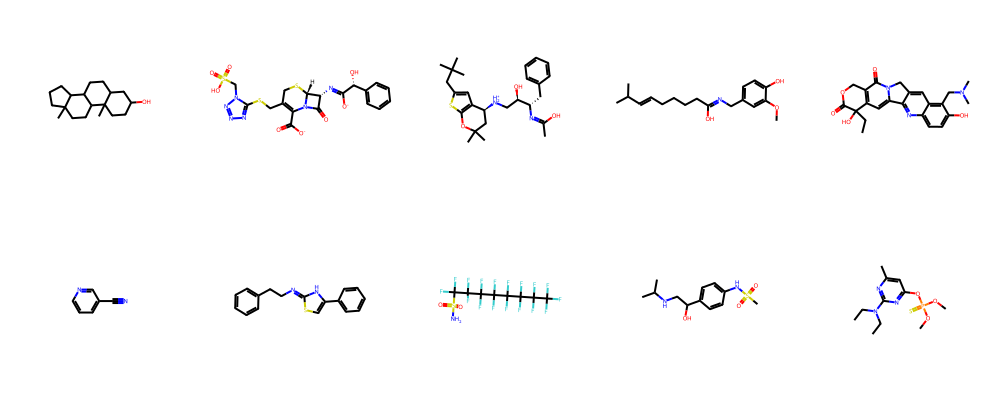

In [6]:
Draw.MolsToGridImage(data['mol'][:10], molsPerRow=5)

In [7]:
y_train = data.loc[:, 'task1':'task11'].to_numpy()
y_train


array([[ 0,  0,  0, ..., -1,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  1, ...,  0,  0,  0],
       ...,
       [ 0,  0,  1, ...,  0,  0,  0],
       [ 0,  0,  0, ..., -1,  0,  0],
       [ 0,  0,  0, ..., -1,  0,  0]])

In [8]:
# Initialize fp generator
mfpgen = Chem.rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)

# Compute fingerprints
fps = np.array([mfpgen.GetFingerprintAsNumPy(mol) for mol in tqdm(data.mol, desc='Compute Morgan fingerprints')])

Compute Morgan fingerprints: 100%|█████| 11951/11951 [00:00<00:00, 23979.71it/s]


In [9]:
fps

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [10]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


def train_and_evaluate(X, y, task_name):
    train_mask = y != 0
    X_masked = X[train_mask]
    y_masked = y[train_mask]
    
    y_binary = (y_masked + 1) / 2
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_binary)
    
    # Split the dataset
    X_train, X_val, y_train, y_val = train_test_split(X_masked, y_encoded, test_size=0.2, random_state = 42)
    
    # Initialize and train the model
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on the validation set and evaluate
    y_pred = model.predict(X_val)
    print(f"Classification report for {task_name}:")
    
    # Convert integer class labels back to strings for classification report
    target_names = [str(cls) for cls in label_encoder.classes_]
    print(classification_report(y_val, y_pred, target_names=target_names))
    
    return model, label_encoder

In [11]:
models = {}
label_encoders = {}
for i in range(y_train.shape[1]):
    task_name = f"task{i+1}"
    print(f"Training model for {task_name}...")
    models[task_name], label_encoders[task_name] = train_and_evaluate(fps, y_train[:, i], task_name)

Training model for task1...
Classification report for task1:
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.85        95
         1.0       0.53      0.29      0.38        31

    accuracy                           0.76       126
   macro avg       0.66      0.60      0.61       126
weighted avg       0.73      0.76      0.74       126

Training model for task2...
Classification report for task2:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       197
         1.0       0.00      0.00      0.00         5

    accuracy                           0.95       202
   macro avg       0.49      0.48      0.49       202
weighted avg       0.95      0.95      0.95       202

Training model for task3...
Classification report for task3:
              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80       111
         1.0       0.76      0.79      0.77        94


In [12]:
from sklearn.model_selection import RandomizedSearchCV

def tune_hyperparameters(X, y, task_name, param_grid):
    train_mask = y != 0
    X_masked = X[train_mask]
    y_masked = y[train_mask]
    
    # Convert labels to binary format (0 and 1)
    y_binary = (y_masked + 1) / 2
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_binary)
    
    model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    search = RandomizedSearchCV(model, param_grid, n_iter=30, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)
    
    search.fit(X_masked, y_encoded)
    
    print(f"\nBest parameters for {task_name}: {search.best_params_}")
    print(f"Best score for {task_name}: {search.best_score_}")
    
    return search.best_estimator_, label_encoder

In [14]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'learning_rate': [0.001, 0.01, 0.05],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5, 1],  # L1 regularization term on weights
    'reg_lambda': [1, 0.5, 0.1, 0],  # L2 regularization term on weights
    'scale_pos_weight': [1, 2, 3],  # Balancing of positive and negative weights
    'max_delta_step': [0, 0.1, 0.5, 1],  # Helps in logistic regression
    'tree_method': ['auto', 'exact', 'approx', 'hist'],  # Tree construction algorithm
}

best_models = {}
label_encoders={}

# Loop through each task
for i in range(y_train.shape[1]):
    task_name = f"task{i+1}"
    print(f"Tuning hyperparameters for {task_name} with expanded parameter grid...")
    best_model, label_encoder = tune_hyperparameters(fps, y_train[:, i], task_name, param_grid)
    
    best_models[task_name] = best_model
    label_encoders[task_name] = label_encoder

Tuning hyperparameters for task1 with expanded parameter grid...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters for task1: {'tree_method': 'hist', 'subsample': 0.7, 'scale_pos_weight': 1, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 6, 'max_delta_step': 0, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best score for task1: 0.815047619047619
Tuning hyperparameters for task2 with expanded parameter grid...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters for task2: {'tree_method': 'exact', 'subsample': 1.0, 'scale_pos_weight': 3, 'reg_lambda': 0, 'reg_alpha': 0.5, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 4, 'max_delta_step': 1, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.9}
Best score for task2: 0.9415841584158414
Tuning hyperparameters for task3 with expanded parameter grid...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_delta_step=0, max_depth=5, min_child_weight=3, n_estimators=150, reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=1.0, tree_method=approx; total time=   2.0s[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_delta_step=0.1, max_depth=4, min_child_weight=2, n_estimators=250, reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=2, subsample=0.7, tree_method=hist; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_delta_step=0.5, max_depth=3, min_child_weight=2, n_estimators=150, reg_alpha=0, reg_lambda=1, scale_pos_weight=3, subsample=1.0, tree_method=hist; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_delta_step=0.5, max_depth=3, min_child_weight=2, n_estimators=150, reg_alpha=0, reg_lambda=1, scale_pos_weight=3, subsample=1.0, tree_method=hist; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_del

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_delta_step=0, max_depth=6, min_child_weight=3, n_estimators=250, reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=2, subsample=0.7, tree_method=hist; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_delta_step=0, max_depth=6, min_child_weight=3, n_estimators=250, reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=2, subsample=0.7, tree_method=hist; total time=   0.7s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.05, max_delta_step=0.1, max_depth=4, min_child_weight=2, n_estimators=150, reg_alpha=1, reg_lambda=0, scale_pos_weight=1, subsample=1.0, tree_method=exact; total time=   2.7s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_delta_step=0.1, max_depth=6, min_child_weight=2, n_estimators=200, reg_alpha=0.1, reg_lambda=0, scale_pos_weight=3, subsample=0.7, tree_method=approx; total time=   3.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_d

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_delta_step=0.1, max_depth=4, min_child_weight=2, n_estimators=250, reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=2, subsample=0.7, tree_method=hist; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_delta_step=0.1, max_depth=4, min_child_weight=2, n_estimators=250, reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=2, subsample=0.7, tree_method=hist; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_delta_step=0.5, max_depth=3, min_child_weight=2, n_estimators=150, reg_alpha=0, reg_lambda=1, scale_pos_weight=3, subsample=1.0, tree_method=hist; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_delta_step=0, max_depth=3, min_child_weight=2, n_estimators=200, reg_alpha=1, reg_lambda=0.1, scale_pos_weight=2, subsample=0.8, tree_method=auto; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_delta_step=0, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.7, tree_method=exact; total time=   3.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_delta_step=0, max_depth=5, min_child_weight=2, n_estimators=200, reg_alpha=0.5, reg_lambda=0, scale_pos_weight=3, subsample=0.7, tree_method=hist; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=5, min_child_weight=1, n_estimators=250, reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=3, subsample=1.0, tree_method=hist; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_delta_step=0.5, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=1, scale_pos_weight=2, subsample=0.8, tree_method=exact; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_


Best parameters for task6: {'tree_method': 'approx', 'subsample': 1.0, 'scale_pos_weight': 2, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 2, 'max_depth': 6, 'max_delta_step': 0, 'learning_rate': 0.001, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best score for task6: 0.9873684210526316
Tuning hyperparameters for task7 with expanded parameter grid...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_delta_step=0, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.7, tree_method=exact; total time=   3.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_delta_step=0, max_depth=5, min_child_weight=2, n_estimators=200, reg_alpha=0.5, reg_lambda=0, scale_pos_weight=3, subsample=0.7, tree_method=hist; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=5, m

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_delta_step=0, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.7, tree_method=exact; total time=   3.1s
[CV] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.05, max_delta_step=1, max_depth=6, min_child_weight=1, n_estimators=150, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=1.0, tree_method=auto; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_delta_step=0, max_depth=5, min_child_weight=2, n_estimators=200, reg_alpha=0.5, reg_lambda=0, scale_pos_weight=3, subsample=0.7, tree_method=hist; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_delta_step=0.1, max_depth=6, min_child_weight=1, n_estimators=200, reg_alpha=1, reg_lambda=0.5, scale_pos_weight=1, subsample=0.8, tree_method=hist; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_de

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_delta_step=0, max_depth=5, min_child_weight=1, n_estimators=200, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=0.7, tree_method=exact; total time=   3.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.001, max_delta_step=0, max_depth=5, min_child_weight=2, n_estimators=200, reg_alpha=0.5, reg_lambda=0, scale_pos_weight=3, subsample=0.7, tree_method=hist; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=5, min_child_weight=1, n_estimators=250, reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=3, subsample=1.0, tree_method=hist; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_delta_step=0.1, max_depth=6, min_child_weight=1, n_estimators=200, reg_alpha=1, reg_lambda=0.5, scale_pos_weight=1, subsample=0.8, tree_method=hist; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_de


Best parameters for task7: {'tree_method': 'exact', 'subsample': 0.7, 'scale_pos_weight': 1, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 250, 'min_child_weight': 2, 'max_depth': 4, 'max_delta_step': 1, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}
Best score for task7: 0.8674571154906685
Tuning hyperparameters for task8 with expanded parameter grid...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters for task8: {'tree_method': 'approx', 'subsample': 0.8, 'scale_pos_weight': 2, 'reg_lambda': 0.5, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 6, 'max_delta_step': 0, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.9}
Best score for task8: 0.8676215445996011
Tuning hyperparameters for task9 with expanded parameter grid...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=5, min_child_weight=2, n_est

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_delta_step=0.1, max_depth=4, min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0, scale_pos_weight=1, subsample=1.0, tree_method=auto; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_delta_step=0.1, max_depth=4, min_child_weight=2, n_estimators=100, reg_alpha=0.1, reg_lambda=0, scale_pos_weight=1, subsample=1.0, tree_method=auto; total time=   0.1s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_delta_step=0, max_depth=4, min_child_weight=2, n_estimators=150, reg_alpha=0.5, reg_lambda=0, scale_pos_weight=2, subsample=0.9, tree_method=exact; total time=   1.9s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=1, max_depth=6, min_child_weight=2, n_estimators=250, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0, tree_method=hist; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_delta_ste


Best parameters for task9: {'tree_method': 'hist', 'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 6, 'max_delta_step': 1, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best score for task9: 0.9364403567117352
Tuning hyperparameters for task10 with expanded parameter grid...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_delta_step=0.5, max_depth=6, min_child_weight=1, n_estimators=100, reg_alpha=1, reg_lambda=0, scale_pos_weight=3, subsample=0.9, tree_method=hist; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0.5, max_depth=4, min_child_weight=1, n_estimators=200, reg_alpha=1, reg_lambda=0.1, scale_pos_weight=3, subsample=1.0, tree_method=exact; total time=   2.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0.5, max_depth=4, m

[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_delta_step=0.5, max_depth=6, min_child_weight=3, n_estimators=200, reg_alpha=0, reg_lambda=0, scale_pos_weight=2, subsample=1.0, tree_method=auto; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.001, max_delta_step=0.5, max_depth=3, min_child_weight=1, n_estimators=150, reg_alpha=1, reg_lambda=0.1, scale_pos_weight=3, subsample=0.7, tree_method=auto; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.001, max_delta_step=0.5, max_depth=3, min_child_weight=1, n_estimators=150, reg_alpha=1, reg_lambda=0.1, scale_pos_weight=3, subsample=0.7, tree_method=auto; total time=   0.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_delta_step=1, max_depth=4, min_child_weight=2, n_estimators=250, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=3, subsample=0.8, tree_method=approx; total time=   4.5s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_

[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.05, max_delta_step=0, max_depth=4, min_child_weight=2, n_estimators=150, reg_alpha=0.5, reg_lambda=0, scale_pos_weight=2, subsample=0.9, tree_method=exact; total time=   2.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=1, max_depth=6, min_child_weight=2, n_estimators=250, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0, tree_method=hist; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_delta_step=1, max_depth=6, min_child_weight=1, n_estimators=150, reg_alpha=0.1, reg_lambda=0.5, scale_pos_weight=1, subsample=0.7, tree_method=auto; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_delta_step=0, max_depth=4, min_child_weight=2, n_estimators=250, reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=3, subsample=0.8, tree_method=hist; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_delta_s

[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=6, min_child_weight=2, n_estimators=150, reg_alpha=0, reg_lambda=0.5, scale_pos_weight=2, subsample=0.9, tree_method=auto; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.001, max_delta_step=1, max_depth=4, min_child_weight=2, n_estimators=100, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.7, tree_method=approx; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.001, max_delta_step=1, max_depth=6, min_child_weight=1, n_estimators=250, reg_alpha=0.5, reg_lambda=0.5, scale_pos_weight=3, subsample=1.0, tree_method=approx; total time=   3.4s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_delta_step=1, max_depth=3, min_child_weight=1, n_estimators=250, reg_alpha=1, reg_lambda=0.1, scale_pos_weight=2, subsample=1.0, tree_method=exact; total time=   2.0s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_s

[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_delta_step=1, max_depth=4, min_child_weight=2, n_estimators=250, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=3, subsample=0.8, tree_method=approx; total time=   4.5s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_delta_step=0.5, max_depth=5, min_child_weight=3, n_estimators=200, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.7, tree_method=approx; total time=   3.5s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_delta_step=1, max_depth=5, min_child_weight=1, n_estimators=150, reg_alpha=0, reg_lambda=0, scale_pos_weight=2, subsample=1.0, tree_method=auto; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_delta_step=0, max_depth=5, min_child_weight=3, n_estimators=250, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=2, subsample=0.9, tree_method=hist; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_delta_


Best parameters for task10: {'tree_method': 'exact', 'subsample': 0.9, 'scale_pos_weight': 3, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 150, 'min_child_weight': 3, 'max_depth': 6, 'max_delta_step': 0, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.9}
Best score for task10: 0.9234774287965777
Tuning hyperparameters for task11 with expanded parameter grid...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_delta_step=0.5, max_depth=5, min_child_weight=3, n_estimators=200, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.7, tree_method=approx; total time=   3.5s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_delta_step=1, max_depth=6, min_child_weight=2, n_estimators=200, reg_alpha=0, reg_lambda=0.1, scale_pos_weight=2, subsample=0.8, tree_method=exact; total time=   4.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.01, max_delta_step=1, max_depth=


Best parameters for task11: {'tree_method': 'exact', 'subsample': 1.0, 'scale_pos_weight': 1, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 4, 'max_delta_step': 0, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.9}
Best score for task11: 0.9375965316352799


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Initialize a dictionary to store final models for each task
final_models = {}

# Initialize a dictionary to store evaluation metrics for each task
evaluation_metrics = {}

tasks = [f'task{i+1}' for i in range(y_train.shape[1])]

for task_index, task in enumerate(tasks):
    print(f"\nTraining and evaluating model for {task}...")
    
    # Apply masking
    train_mask = y_train[:, task_index] != 0
    X_masked = fps[train_mask]
    y_masked = y_train[train_mask, task_index]
    
    # Convert labels to binary format (0 and 1)
    y_binary = (y_masked + 1) / 2
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_binary)
    
    # Split the data (use a proper test set if available)
    X_train, X_test, y_encoded_train, y_encoded_test = train_test_split(X_masked, y_encoded, test_size=0.2, random_state=42)
    
    # Initialize and train the model with the best hyperparameters
    best_params = best_models[task].get_params()  # Retrieve the best parameters
    model = XGBClassifier(**best_params)
    model.fit(X_train, y_encoded_train)
    
    # Store the trained model
    final_models[task] = model

    # Evaluation
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of the positive class
    y_pred = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions
    
    # Reverse the label encoding for true labels
    y_test = label_encoder.inverse_transform(y_encoded_test)
    
    # Calculate and store the evaluation metrics
    accuracy = accuracy_score(y_encoded_test, y_pred)
    precision = precision_score(y_encoded_test, y_pred)
    recall = recall_score(y_encoded_test, y_pred)
    f1 = f1_score(y_encoded_test, y_pred)
    roc_auc = roc_auc_score(y_encoded_test, y_pred_proba)
    average_precision = average_precision_score(y_encoded_test, y_pred_proba)
    
    evaluation_metrics[task] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC Score': roc_auc,
        'Average Precision': average_precision
    }
    
    # Print out metrics for the current task
    print(f"Evaluation metrics for {task}: {evaluation_metrics[task]}")

# Print the evaluation metrics for each task
print("\nEvaluation Metrics:")
for task, metrics in evaluation_metrics.items():
    print(f"\nTask: {task}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")

avg_metrics = {metric: np.mean([metrics[metric] for metrics in evaluation_metrics.values()]) for metric in evaluation_metrics['task1']}
print("\nAverage Metrics Across Tasks:")
print(avg_metrics)



Training and evaluating model for task1...
Evaluation metrics for task1: {'Accuracy': 0.7857142857142857, 'Precision': 0.7, 'Recall': 0.22580645161290322, 'F1 Score': 0.34146341463414637, 'ROC AUC Score': 0.7239388794567062, 'Average Precision': 0.4764860489999254}

Training and evaluating model for task2...
Evaluation metrics for task2: {'Accuracy': 0.9752475247524752, 'Precision': 0.0, 'Recall': 0.0, 'F1 Score': 0.0, 'ROC AUC Score': 0.5761421319796954, 'Average Precision': 0.09655092647921962}

Training and evaluating model for task3...
Evaluation metrics for task3: {'Accuracy': 0.7902439024390244, 'Precision': 0.7339449541284404, 'Recall': 0.851063829787234, 'F1 Score': 0.7881773399014779, 'ROC AUC Score': 0.8783304581176922, 'Average Precision': 0.8417069131444643}

Training and evaluating model for task4...
Evaluation metrics for task4: {'Accuracy': 0.5158730158730159, 'Precision': 0.48936170212765956, 'Recall': 0.7796610169491526, 'F1 Score': 0.6013071895424836, 'ROC AUC Score'

In [16]:
X_new = pd.read_csv("smiles_test.csv",index_col=0).reset_index(drop=True)
X_new

,smiles
0,COC(=O)C1(C)CCCN1S(C)(=O)=O
1,O=C(N=c1cco[nH]1)c1cccc(Cl)c1
2,CCC(=O)O[C@@]1(C(=O)CCl)[C@@H](C)C[C@H]2[C@@H]...
3,CCCN(CCC)c1c([N+](=O)[O-])cc(S(C)(=O)=O)cc1[N+...
4,COc1ccc([N+](=O)[O-])cc1O
...,...
5891,CCCN(CCC)c1c([N+](=O)[O-])cc(S(N)(=O)=O)cc1[N+...
5892,COCC1CN=C(c2ccccc2Cl)c2cc(Br)ccc2N1C
5893,O=C1OCC(Cc2cccc(O)c2)C1Cc1cccc(O)c1
5894,CN1C[C@](C)(c2cccc(NC(=O)c3ccc(Cl)cn3)c2)N=C(N...


Convert SMILES to rdkit mols: 100%|██████| 5896/5896 [00:00<00:00, 11598.70it/s]


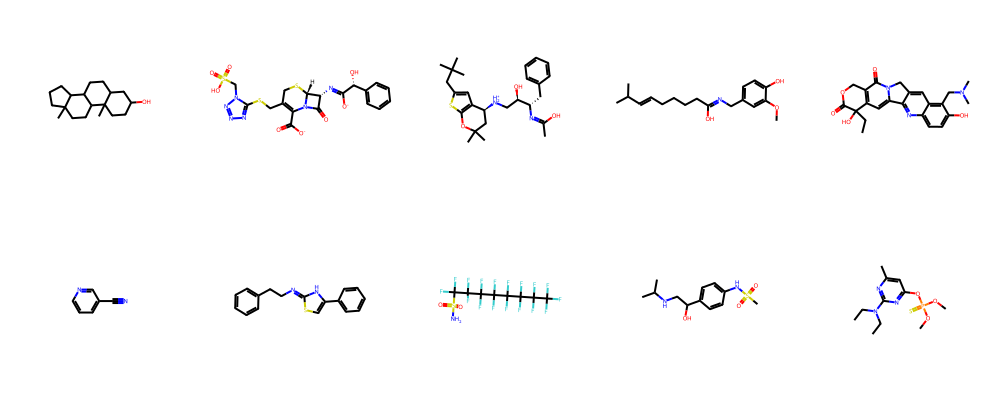

In [17]:
X_new['mol'] = [Chem.MolFromSmiles(smi) for smi in tqdm(X_new['smiles'], desc='Convert SMILES to rdkit mols')]
Draw.MolsToGridImage(data['mol'][:10], molsPerRow=5)

In [18]:
X_new_fps = np.array([mfpgen.GetFingerprintAsNumPy(mol) for mol in tqdm(X_new.mol, desc='Compute Morgan fingerprints')])

Compute Morgan fingerprints: 100%|███████| 5896/5896 [00:00<00:00, 22230.27it/s]


In [19]:
X_new_fps

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [20]:
predictions = {}
prediction_probabilities = {}

for task, model in final_models.items():
    predictions[task] = model.predict(X_new_fps)
    prediction_probabilities[task] = model.predict_proba(X_new_fps)

In [21]:
pd.DataFrame(predictions)

,task1,task2,task3,task4,task5,task6,task7,task8,task9,task10,task11
0,0,0,0,1,1,0,1,0,0,0,0
1,0,0,0,1,1,0,1,0,0,0,0
2,0,0,0,1,1,0,1,1,0,0,0
3,0,0,0,1,1,0,1,0,0,0,0
4,0,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
5891,0,0,0,1,1,0,1,0,0,0,0
5892,0,0,0,1,1,0,1,0,0,0,0
5893,0,0,0,1,1,0,1,0,0,0,0
5894,0,0,0,1,1,0,1,1,0,0,0


In [22]:
for task, pred_encoded in predictions.items():
    # Reverse label encoding to original labels using the stored label encoder
    label_encoder = label_encoders[task]
    pred_original = label_encoder.inverse_transform(pred_encoded)
    
    # Overwrite the predictions with the original labels
    predictions[task] = pred_original

In [23]:
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv("predictions_all_tasks.csv", index=True)


In [1]:
for task, probs in prediction_probabilities.items():
    if isinstance(probs, np.ndarray) and probs.ndim == 2:
        prediction_probabilities[task] = probs[:, 1]  # This assumes class 1 is the 'positive' class

probabilities_df = pd.DataFrame(prediction_probabilities)

probabilities_df.to_csv("prediction_probabilities.csv", index=True)


NameError: name 'prediction_probabilities' is not defined